# An Exploration of eBay Car Sales Data

Thanks to the pandemic, vehicle prices have skyrocketed.  Both new and used cars are selling at historically high levels due to chip shortages and consumer demand.  Thanks to a webscraping provided by user orgesleka, we can see a snapshot of what the German Ebay car market looked like in 2016.  Using the pandas library, I will clean their data as well as perform an exploratory analysis.  An additional file will be uploaded to automate this process should the end user need to perform this analysis for different date periods.

# Data Dictionary:
The following is an overview of the 20 columns in the dataset:

-  **dateCrawled** - When this ad was first crawled. All field-values are taken from this date.
-  **name** - Name of the car.
-  **seller** - Whether the seller is private or a dealer.
-  **offerType** - The type of listing
-  **price** - The price on the ad to sell the car.
-  **abtest** - Whether the listing is included in an A/B test.
-  **vehicleType** - The vehicle Type.
-  **yearOfRegistration** - The year in which the car was first registered.
-  **gearbox** - The transmission type.
-  **powerPS** - The power of the car in PS.
-  **model** - The car model name.
-  **kilometer** - How many kilometers the car has driven.
-  **monthOfRegistration** - The month in which the car was first registered.
-  **fuelType** - What type of fuel the car uses.
-  **brand** - The brand of the car.
-  **notRepairedDamage** - If the car has a damage which is not yet repaired.
-  **dateCreated** - The date on which the eBay listing was created.
-  **nrOfPictures** - The number of pictures in the ad.
-  **postalCode** - The postal code for the location of the vehicle.
-  **lastSeenOnline** - When the crawler saw this ad last online.

In [1]:
import pandas as pd
import numpy as np
import re
import tabulate as tab
import datetime as dt
import jupyter
import matplotlib.pyplot as plt

In [2]:
autos = pd.read_csv('autos.csv', encoding='Latin-1')

In [3]:
autos.info()
autos.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


**Observations**
-  By running the .info() and .head() functions the following was able to be determined:
     -  The dataset contains 20 columns and 371,528 rows
     -  We have 5 columns that contain null values (vehicleType (10% null entries), gearbox (5% null entries), model (6% null entries),fuelType (9% null entries), and notRepairedDamage (19% null entries))
     -  Titles are in CamelCase instead of SnakeCase.
     -  dateCreated, lastSeen, and dateCrawled have their date information stored as object/string data instead of dates and will need to be cleaned.

**Data Cleaning**:
-  **1. Cleaning Column Names**
    -  The first item I will clean is the file's column names.  For easier analysis I will convert all camelCase entries to snake_case using regex.  Additionally, the "client" specified specific naming conventions for certain rows which will be adjusted after the snake_case conversion.  (To note, normal Python conventions reocommend that we use snake_case, hence why we are changing the column titles.)

In [4]:
columns = autos.columns
titles = []
for title in columns:
    snake = re.sub('([A-Z]+)', r'_\1', title).lower()
    titles.append(snake)
autos.columns = titles
    # The specified 6 titles are converted below|
autos.rename({'year_of_registration': 'registration_year'}, axis=1, inplace=True)
autos.rename({'month_of_registration': 'registration_month'}, axis=1, inplace=True)
autos.rename({'not_repaired_damage': 'unrepaired_damage'}, axis=1, inplace=True)
autos.rename({'date_created': 'ad_created'}, axis=1, inplace=True)
autos.rename({'nr_of_pictures':'num_of_pictures'}, axis=1, inplace=True)
autos.rename({'kilometer': 'odometer_km'}, axis=1, inplace=True)

Since the file originates from German Ebay, the string entries are all in German.  As a non-German speaker it will be easier to perform analysis with English entries.  The price category will also be converted from Euros to USD.

In [5]:
'''
If you would like to see how I quickly determined which words to change please remove
the quotes
german_list = ['seller', 'offer_type', 'vehicle_type', 'gearbox',
               'fuel_type', 'unrepaired_damage']
for title in german_list:
    print(autos[title].unique())
    '''

seller_dict = {'privat':'private', 'gewerblich':'commercial'}
sell = autos['seller']
autos['seller'] = sell.map(seller_dict)

offer_dict = {'Angebot':'Offer', 'Gesuch': 'Request'}
of = autos['offer_type']
autos['offer_type'] = of.map(offer_dict)

vehicle_dict = {'coupe': 'coupe', 'kleinwagen': 'compact', 'limousine': 'limousine',
                    'cabrio': 'convertible', 'bus': 'bus', 'kombi': 'station wagon',
                    'andere': 'other'}
vehicle_type = autos['vehicle_type']
autos['vehicle_type'] = vehicle_type.map(vehicle_dict)

gear_dict = {'manuell': 'manual', 'automatik': 'automatic'}
gear = autos['gearbox']
autos['gearbox'] = gear.map(gear_dict)

fuel_dict = {'benzin': 'petrol', 'diesel': 'diesel', 'lpg': 'lpg', 'andere': 'alternative',
                 'hibrid': 'hybrid', 'cng': 'cng', 'elektro': 'electric'}
fuel = autos['fuel_type']
autos['fuel_type'] = fuel.map(fuel_dict)

repair_dict = {'ja': 'yes', 'nein': 'no'}
repair = autos['unrepaired_damage']
autos['unrepaired_damage'] = repair.map(repair_dict)

autos['price'] = autos['price']*.93

Now that the entries are in german, we need to determine if all data is worth exploring.
By running a for loop we can determine general descriptions.  We will be able to see that all entries of "Number of Pictures" results in a value of zero.  Therefore, I will remove it from our dataset.

In [6]:
'''
columns = autos.columns
for entry in columns:
    formatted = autos[entry].describe
    print(formatted)
    '''
print(autos['num_of_pictures'].describe)
autos.drop('num_of_pictures', axis=1, inplace=True)

<bound method NDFrame.describe of 0         0
1         0
2         0
3         0
4         0
         ..
371523    0
371524    0
371525    0
371526    0
371527    0
Name: num_of_pictures, Length: 371528, dtype: int64>


With the superfluous column removed we should look at the dataset again to determine further areas that require investigation/cleaning.

In [7]:
autos.describe(include='all')

,date_crawled,name,seller,offer_type,price,abtest,vehicle_type,registration_year,gearbox,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
count,371528,371528,371528,371528,3.715280e+05,371528,318952,371528.000000,351319,371528.000000,351044,371528.000000,371528.000000,337864,371528,299468,371528,371528.00000,371528
unique,280500,233531,2,2,NaN,2,7,NaN,2,NaN,251,NaN,NaN,6,40,2,114,NaN,182806
top,2016-03-24 14:49:47,Ford_Fiesta,private,Offer,NaN,test,limousine,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,2016-04-07 06:45:59
freq,7,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,NaN,223857,79640,263182,14450,NaN,17
mean,NaN,NaN,NaN,NaN,1.608448e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,5.734445,NaN,NaN,NaN,NaN,50820.66764,NaN
std,NaN,NaN,NaN,NaN,3.336797e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,3.712412,NaN,NaN,NaN,NaN,25799.08247,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,1067.00000,NaN
25%,NaN,NaN,NaN,NaN,1.069500e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,30459.00000,NaN
50%,NaN,NaN,NaN,NaN,2.743500e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,49610.00000,NaN
75%,NaN,NaN,NaN,NaN,6.696000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,71546.00000,NaN


Any columns containing predominately single values will be considered for removal.  From the chart above I determined that seller, offer_type, abtest, gearbox, and unrepaired_damage require further investigation.


In [8]:
investigate = ['seller', 'offer_type', 'abtest', 'gearbox', 'unrepaired_damage']
for title in investigate:
    print('='*20)
    print('Column: ', title)
    print(autos[title].value_counts())
    print('='*20)

Column:  seller
private       371525
commercial         3
Name: seller, dtype: int64
Column:  offer_type
Offer      371516
Request        12
Name: offer_type, dtype: int64
Column:  abtest
test       192585
control    178943
Name: abtest, dtype: int64
Column:  gearbox
manual       274214
automatic     77105
Name: gearbox, dtype: int64
Column:  unrepaired_damage
no     263182
yes     36286
Name: unrepaired_damage, dtype: int64


The seller and offer_type columns both have an extremely high proportions of answers in as a single value ("private", and "Offer" respectively).  Since the density of these answers are not helpful for our analysis I will drop them from our dataset.

In [9]:
autos.drop(['seller', 'offer_type'], axis=1, inplace=True)

-  **2. Reformating Numeric Data**
    -  In 7 demonstrates that the odemeter category is of type float.  For ease of analysis I will convert it to int type.

In [10]:
autos['odometer_km'] = (autos['odometer_km'].astype(int))

In [11]:
autos['odometer_km'].head(3)

0    150000
1    125000
2    125000
Name: odometer_km, dtype: int32

**3. Addressing Numeric Outliers**
- Before analyzing the data, we should first determine if there are any outliers within the odometer and price columns

In [12]:
autos[['odometer_km', 'price']].describe()

,odometer_km,price
count,371528.000000,3.715280e+05
mean,125618.688228,1.608448e+04
std,40112.337051,3.336797e+06
min,5000.000000,0.000000e+00
25%,125000.000000,1.069500e+03
50%,150000.000000,2.743500e+03
75%,150000.000000,6.696000e+03
max,150000.000000,1.997160e+09


**Observations**:
-  odometer_km:
    -  The median and the third quartile are the same value, therefore we will not experience any outliers from this category.
-  price
    - There are two issues that can be determined immediately.  
        - The max value of 1,997,160,000 will skew our results to the right.  
        - Additionally, it appears that there are multiple 0 price entries which will not be useful in analysis as they were likely given as gifts.

Price Outlier Removal:
* Interquartile Range (IQR) = 6,696.00 - 1,069.50 = 5,626.50
* Lower Fence = 1,069.50 - (1.50 * 5,626.50) = -7,370.25
* Upper Fence = 6,696.00 + (1.50 * 5,626.50) = 15,135.75

Lower inner fences can be negative, even if all the data is strictly positive.  However, to determine the risk of eliminating all $0 price entries we will first determine their proportion in the dataset.

In [13]:
autos['price'].value_counts().head(1)

0.0    10778
Name: price, dtype: int64

Recall that we have 371,528 entries in the dataset.  All instances of a $0 price make up about 3% of all entries and therefore can be discarded.  This will be done quickly using pandas between() function.  The values that we will keep will be set between 1 and the Upper Fence determined above.

In [14]:
autos = autos[autos['price'].between(1,15135.75)]
autos['price'].value_counts().min()

autos['price'].describe()

count    331453.000000
mean       3835.308157
std        3574.828289
min           1.860000
25%        1115.070000
50%        2557.500000
75%        5579.070000
max       15131.100000
Name: price, dtype: float64

**Observations**:
- The dataset has been reduced by 40075 rows.  While our data will still be skewed due to the 1 price entries, all rows have been made to be a tangible value and outliers eliminated.
- The standard deviation has reduced to 3,573.28, which is considerable more reasonable than the original 3,336,797 standard deviation suggested before the outliers were removed.
- The maximum price is better approximated at 15,131.10 as 1,997,160,000 is impossible for the average consumer

**4. Exploring the Date Columns**:
* There are 3 date columns that are identified as a string:
    4a) date_crawled
    4b) last_seen
    4c) ad_created
* Additionally, the registration_month and registration_year columns are properly formatted and can have distribution processing done without any added steps

**4a) Date Crawled**

In [15]:
date_crawled = (autos['date_crawled'].str[:10].value_counts(normalize=True, dropna=False).round(3).sort_index())
print(tab.tabulate(date_crawled.to_frame(), headers=['Date', 'Percent Crawled'], tablefmt='pipe'))

| Date       |   Percent Crawled |
|:-----------|------------------:|
| 2016-03-05 |             0.026 |
| 2016-03-06 |             0.015 |
| 2016-03-07 |             0.036 |
| 2016-03-08 |             0.034 |
| 2016-03-09 |             0.034 |
| 2016-03-10 |             0.033 |
| 2016-03-11 |             0.033 |
| 2016-03-12 |             0.036 |
| 2016-03-13 |             0.016 |
| 2016-03-14 |             0.036 |
| 2016-03-15 |             0.033 |
| 2016-03-16 |             0.03  |
| 2016-03-17 |             0.032 |
| 2016-03-18 |             0.013 |
| 2016-03-19 |             0.035 |
| 2016-03-20 |             0.036 |
| 2016-03-21 |             0.036 |
| 2016-03-22 |             0.033 |
| 2016-03-23 |             0.032 |
| 2016-03-24 |             0.03  |
| 2016-03-25 |             0.033 |
| 2016-03-26 |             0.032 |
| 2016-03-27 |             0.03  |
| 2016-03-28 |             0.035 |
| 2016-03-29 |             0.034 |
| 2016-03-30 |             0.033 |
| 2016-03-31 |      

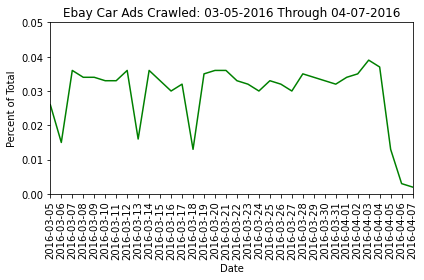

In [16]:
plt.rcParams['figure.figsize'] = [8,3.5]
plt.rcParams['figure.autolayout'] = True
plt.xticks(range(len(date_crawled.index)),date_crawled.index, rotation='vertical')
plt.margins(x=0,y=0)
plt.xlabel('Date')
plt.ylabel('Percent of Total')
fig = plt.gca()
plt.plot(date_crawled.index, date_crawled.values, '-g')
fig.set_ylim([0,.05])
plt.title('Ebay Car Ads Crawled: 03-05-2016 Through 04-07-2016')
plt.show()

Through both the table and graph we see that the number of ads crawled per day was fairly consistent as each entry makes up roughly 3.5% of the total scraped data.  Three major drops can be found on consecutive sundays (2016-03-06 and 2016-03-13) and a single Friday (2016-03-18).

**4b) Last Seen**
- We can assume that purpose of the "Last Seen" category is to determine when and how many ads are removed from the marketplace.

In [17]:
last_seen = (autos['last_seen'].str[:10].value_counts(normalize=True, dropna=False).round(3).sort_index())
print(tab.tabulate(last_seen.to_frame(), headers=['Date', 'Percent Last Seen'], tablefmt='pipe'))

| Date       |   Percent Last Seen |
|:-----------|--------------------:|
| 2016-03-05 |               0.001 |
| 2016-03-06 |               0.004 |
| 2016-03-07 |               0.005 |
| 2016-03-08 |               0.008 |
| 2016-03-09 |               0.01  |
| 2016-03-10 |               0.012 |
| 2016-03-11 |               0.013 |
| 2016-03-12 |               0.024 |
| 2016-03-13 |               0.009 |
| 2016-03-14 |               0.013 |
| 2016-03-15 |               0.017 |
| 2016-03-16 |               0.017 |
| 2016-03-17 |               0.03  |
| 2016-03-18 |               0.007 |
| 2016-03-19 |               0.017 |
| 2016-03-20 |               0.021 |
| 2016-03-21 |               0.021 |
| 2016-03-22 |               0.021 |
| 2016-03-23 |               0.019 |
| 2016-03-24 |               0.02  |
| 2016-03-25 |               0.02  |
| 2016-03-26 |               0.016 |
| 2016-03-27 |               0.017 |
| 2016-03-28 |               0.023 |
| 2016-03-29 |               0.024 |
|

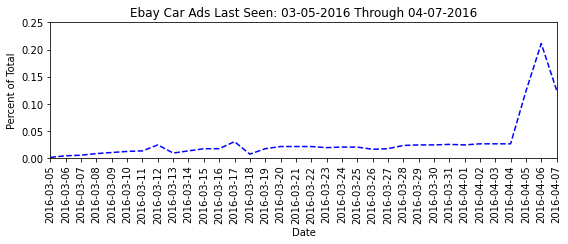

In [18]:
plt.rcParams['figure.figsize'] = [8,3.5]
plt.rcParams['figure.autolayout'] = True
plt.xticks(range(len(last_seen.index)),last_seen.index, rotation='vertical')
plt.margins(x=0,y=0)
plt.xlabel('Date')
plt.ylabel('Percent of Total')
fig = plt.gca()
plt.plot(last_seen.index, last_seen.values, '--b')
fig.set_ylim([0,.25])
plt.title('Ebay Car Ads Last Seen: 03-05-2016 Through 04-07-2016')
plt.show()

**Observations:**
- The graph demonstrated a spike in removals on April 6th (a Wednesday).
- While unusual upon first inspection, there could be a routine ad removal performed by Ebay not accounted for by the scraper.

**4c) Ads Created Per Day**

In [19]:
ad_created = (autos['ad_created'].str[:10].value_counts(normalize=True, dropna=False).round(3).sort_index())
print(tab.tabulate(last_seen.to_frame(), headers=['Date', 'Percent Created'], tablefmt='pipe'))

| Date       |   Percent Created |
|:-----------|------------------:|
| 2016-03-05 |             0.001 |
| 2016-03-06 |             0.004 |
| 2016-03-07 |             0.005 |
| 2016-03-08 |             0.008 |
| 2016-03-09 |             0.01  |
| 2016-03-10 |             0.012 |
| 2016-03-11 |             0.013 |
| 2016-03-12 |             0.024 |
| 2016-03-13 |             0.009 |
| 2016-03-14 |             0.013 |
| 2016-03-15 |             0.017 |
| 2016-03-16 |             0.017 |
| 2016-03-17 |             0.03  |
| 2016-03-18 |             0.007 |
| 2016-03-19 |             0.017 |
| 2016-03-20 |             0.021 |
| 2016-03-21 |             0.021 |
| 2016-03-22 |             0.021 |
| 2016-03-23 |             0.019 |
| 2016-03-24 |             0.02  |
| 2016-03-25 |             0.02  |
| 2016-03-26 |             0.016 |
| 2016-03-27 |             0.017 |
| 2016-03-28 |             0.023 |
| 2016-03-29 |             0.024 |
| 2016-03-30 |             0.024 |
| 2016-03-31 |      

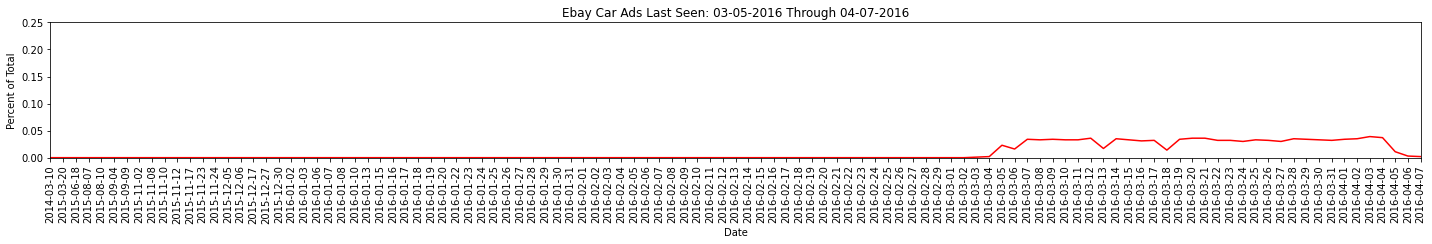

In [20]:
plt.rcParams['figure.figsize'] = [20,3.5]
plt.rcParams['figure.autolayout'] = True
plt.xticks(range(len(ad_created.index)),ad_created.index, rotation='vertical')
plt.margins(x=0,y=0)
plt.xlabel('Date')
plt.ylabel('Percent of Total')
fig = plt.gca()
plt.plot(ad_created.index, ad_created.values, '-r')
fig.set_ylim([0,.25])
plt.title('Ebay Car Ads Last Seen: 03-05-2016 Through 04-07-2016')
plt.show()

**Observations:**
- It appears that the dataset is housing values from March of 2014 to June of 2016.  However, the date first containing a value is consistent with the scrapers start date of March 5th, 2016.
- Further data cleaning will not be done on this graph as the findings will remain the same.  Most ads were created consistently and evenly distributed throughout the month.  It is worth noting that the ads crawled and ads last seen graphs have the same dips in quantity on April 6th, 13th, and 18th.

**5. Registration Year Exploration**

In [21]:
autos['registration_year'].describe()

count    331453.000000
mean       2003.861805
std          75.660604
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: registration_year, dtype: float64

In [22]:
invalid = (~(autos['registration_year'].between(1900,2016))).sum()
print(invalid)
percent_invalid = (invalid/(autos['registration_year'].shape[0]))*100
print('Values outside of the years 1910 and 2016 represent {:.1f}% of the total data'.format(percent_invalid))

13589
Values outside of the years 1910 and 2016 represent 4.1 of the total data


**Observation:**
* The minimum and maximum values of car registration year are impossible as both 1000 and 9999 are not plausable years of registration.  For the purposes of this study we will limit the registration years between 1910 and 2016.

In [23]:
autos = autos[autos['registration_year'].between(1910,2016)]
autos['registration_year'].describe()

count    317864.000000
mean       2002.404588
std           6.751840
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

**Observations:**
* After removing impossible results we can see that 13,589 (%4) of the rows have been removed.
* The IQR is 93, Lower Fence: 1859, and Upper Fence: 2153.  Therefore, there are no outliers within the data.

<AxesSubplot:>

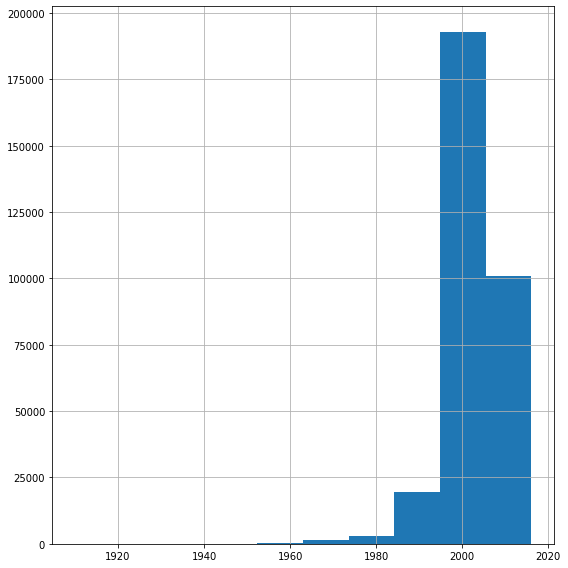

In [28]:
autos['registration_year'].hist(figsize=(8,8))

**Observation:**
- The histogram shows that very few registrations occured between 1910 and 1983, with the majority of registrations occuring between 1984 and 2016.  This is likely explained by legislation and record keeping improvements for car registrations.

**6. Exploring Price by Brand**

In [29]:
make = autos['brand'].value_counts(normalize=True)
top_10 = make.head(10).round(2)
print(tab.tabulate(make.to_frame(), headers=['Brand', '% of listings'], tablefmt='pipe'))

| Make           |   % of listings |
|:---------------|----------------:|
| volkswagen     |     0.215117    |
| opel           |     0.114008    |
| bmw            |     0.102821    |
| mercedes_benz  |     0.0893338   |
| audi           |     0.081085    |
| ford           |     0.0723894   |
| renault        |     0.0512766   |
| peugeot        |     0.0324227   |
| fiat           |     0.0277477   |
| seat           |     0.0195304   |
| mazda          |     0.0162428   |
| skoda          |     0.0160635   |
| smart          |     0.0155664   |
| citroen        |     0.0149435   |
| nissan         |     0.0140626   |
| toyota         |     0.0135309   |
| hyundai        |     0.010344    |
| volvo          |     0.00923665  |
| mitsubishi     |     0.00871127  |
| mini           |     0.00867981  |
| honda          |     0.00803803  |
| sonstige_autos |     0.00766051  |
| kia            |     0.00690862  |
| suzuki         |     0.0068803   |
| alfa_romeo     |     0.00663491  |
|

In [32]:
top_brands = (autos['brand'].value_counts().head(5).index)
print(top_brands)

Index(['volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi'], dtype='object')


In [47]:
agg_price = dict()
for brand in top_brands:
    price = autos['price'][autos['brand']==brand]
    mean_p = price.mean()
    agg_price[brand] = int(mean_p)

p_series = pd.Series(agg_price).sort_values(ascending=False)

agg_dist = dict()
for km in top_brands:
    kilometers = autos['odometer_km'][autos['brand']==km]
    mean_km = kilometers.mean()
    agg_dist[km] = int(mean_km)

km_series = pd.Series(agg_dist)
agg_df = pd.DataFrame(data=p_series, columns=['mean_price'])
agg_df['mean_odometer_km']=km_series


print(tab.tabulate(agg_df, headers='keys', tablefmt='pipe'))

|               |   mean_price |   mean_odometer_km |
|:--------------|-------------:|-------------------:|
| bmw           |         5339 |             139316 |
| audi          |         5311 |             138834 |
| mercedes_benz |         4942 |             137605 |
| volkswagen    |         3874 |             132739 |
| opel          |         2547 |             129878 |


**Observations:**
* Recall, The median price for all vehicles sold is $2,557.50.
* It would be natural to assume that as the distance the vehicle has travelled increases, the price decreases.  However, our findings show that this is not necessarily the case.
* BMW has both the highest mean price and the highest mean odometer value, implying that brand name/quality is worth more than the value lost from distance travelled.